# Исследования поведения пользователей мобильного приложения по продаже продуктов питания

- В качестве аналитика данных в стартапе, который продаёт продукты питания, мне необходимо разобраться - как ведут себя пользователи нашего мобильного приложения.

Используя данные логов пользователей, мы изучим воронку продаж и узнаем, сколько пользователей доходит до покупки, а сколько — останавливается на предыдущих шагах, каких именно, почему и что можно сделать для улучшения ситуации.

- Также перед нами стоит задача - исследовать результаты А/А/В-эксперимента по изменению шрифтов в приложении и влиянию этих изменений на поведение пользователей, с целью ответить на вопрос - стоит ли нам внедрять новые шрифты или нет.

In [3]:
# Импорт необходимых библиотек и функций

import pandas as pd
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Установка максимальной ширины для отображения содержимого колонки
pd.set_option('display.max_colwidth', None)

# Установка максимального количества отображаемых колонок
pd.set_option('display.max_columns', None)


def line():
    print('------------------------------------------------------------------')

## Импорт и первичная обработка данных

In [4]:
# Импортируем файл с логами
try:
    df = pd.read_csv('logs_exp.csv', sep='\t') # Сепаратор - знак табуляции
    display(df.head())
    line()
    print(df.info())
except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пуст")
except pd.errors.ParserError:
    print("Ошибка при чтении файла CSV")
except Exception as e:
    print("Произошла ошибка:", e)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


- судя по данным в файле логов, там хранятся:
1. EventName - название события, тип данных - object
2. DeviceIDHash — уникальный идентификатор пользователя, тип данных - int64
3. EventTimestamp — время события, тип данных - int64
4. ExpId — номер эксперимента, к которому относится пользователь, тип данных - int64

В файле логов 244126 записей, пропусков нет.

## Подготовим данные к анализу

**Приведем названия столбцов к принятому стандарту, заменим тип колонки, содержащей время события, на `datetime` и добавим отдельный столбец с датой** 

In [5]:
# Пропишем новые названия колонок
df.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

# Преобразование столбца 'event_timestamp' в тип datetime
# unit='s' указывает, что ваша временная метка представляет собой количество секунд с начала эпохи Unix, 01/01/1970
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

# выделим из него дату в отдельный столбец
df['event_date'] = df['event_timestamp'].dt.date

display(df.head())


,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Проверим данные на дубликаты**

In [6]:
# Сначала проверим на полные дубликаты
print('Полных дубликатов:', df.duplicated().sum())

Полных дубликатов: 413


- удалим их, вероятнее всего, они вызваны техническим сбоем в работе приложения, следует сообщить об этом коллегам

In [7]:
# Удаляем дубликаты и сбрасываем индекс
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

print(df.info())
line()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB
None
------------------------------------------------------------------
                event_name       device_id_hash     event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07

In [8]:
# Теперь проверим на дубликаты по id пользователя + времени события + типу события
print('Неполных дубликатов:', df.duplicated(subset=['device_id_hash', 'event_timestamp', 'event_name']).sum())

Неполных дубликатов: 0


## Изучим и проверим данные

- **Посмотрим на описательные характеристики данных** 

In [9]:
print('Типы событий и их количество:\n')
print(df.groupby('event_name')['event_name'].count().sort_values())
line()
print('Самое раннее время события:', df['event_timestamp'].min())
line()
print('Самое позднее время события:', df['event_timestamp'].max())
line()
print('Уникальных пользователей:')
print(df['device_id_hash'].nunique())
line()
print('Среднее количество событий на пользователя:')
print(round(len(df) / df['device_id_hash'].nunique(), 4))
line()
print('Распределение логов по группам теста:\n')
print(df.groupby('exp_id')['exp_id'].count())

Типы событий и их количество:

event_name
Tutorial                     1018
PaymentScreenSuccessful     34118
CartScreenAppear            42668
OffersScreenAppear          46808
MainScreenAppear           119101
Name: event_name, dtype: int64
------------------------------------------------------------------
Самое раннее время события: 2019-07-25 04:43:36
------------------------------------------------------------------
Самое позднее время события: 2019-08-07 21:15:17
------------------------------------------------------------------
Уникальных пользователей:
7551
------------------------------------------------------------------
Среднее количество событий на пользователя:
32.2756
------------------------------------------------------------------
Распределение логов по группам теста:

exp_id
246    80181
247    77950
248    85582
Name: exp_id, dtype: int64


- посмотрим на распределение логов по временной шкале

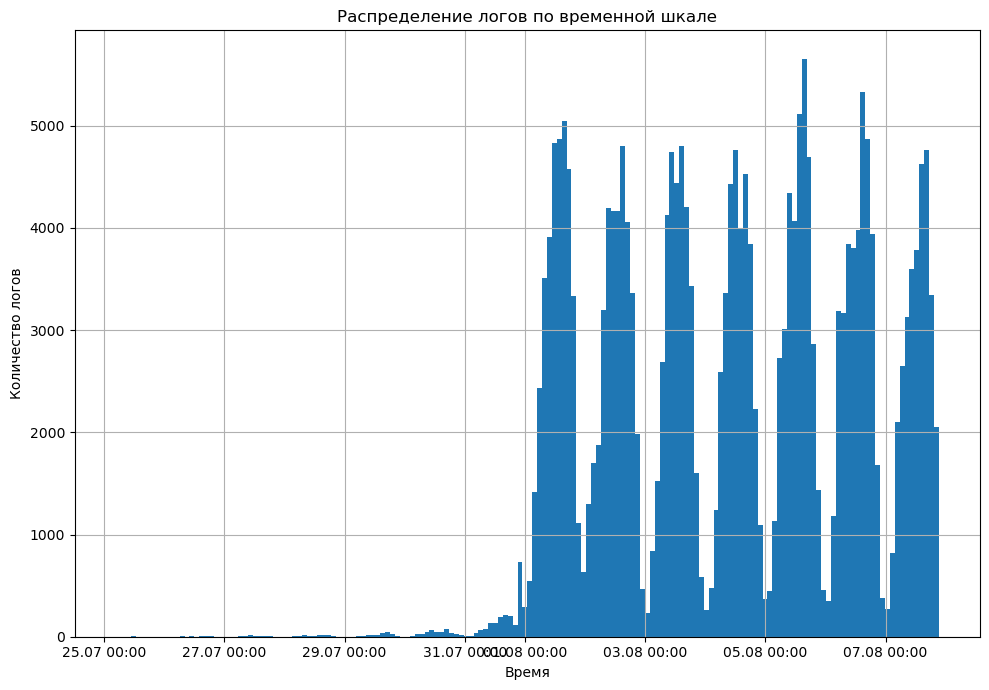

In [10]:
plt.figure(figsize=(10,7))
df['event_timestamp'].hist(bins=168)

# Устанавливаем формат временных меток, без года
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

plt.title('Распределение логов по временной шкале')
plt.ylabel('Количество логов')
plt.xlabel('Время')
plt.tight_layout()
plt.show()

- любопытно: гистограмма показывает, что активность пользователей в приложении резко возрасла с 2019-08-01, а до этого была очень слабой. Это может быть связано с техническими проблемами системы сбора логов, выходом приложения в открытый доступ (окончание бета-периода) и другими причинами.
- ежедневное количество активности примерно одинаковое

**Посмотрим покрупнее на промежуток времени в несколько дней**

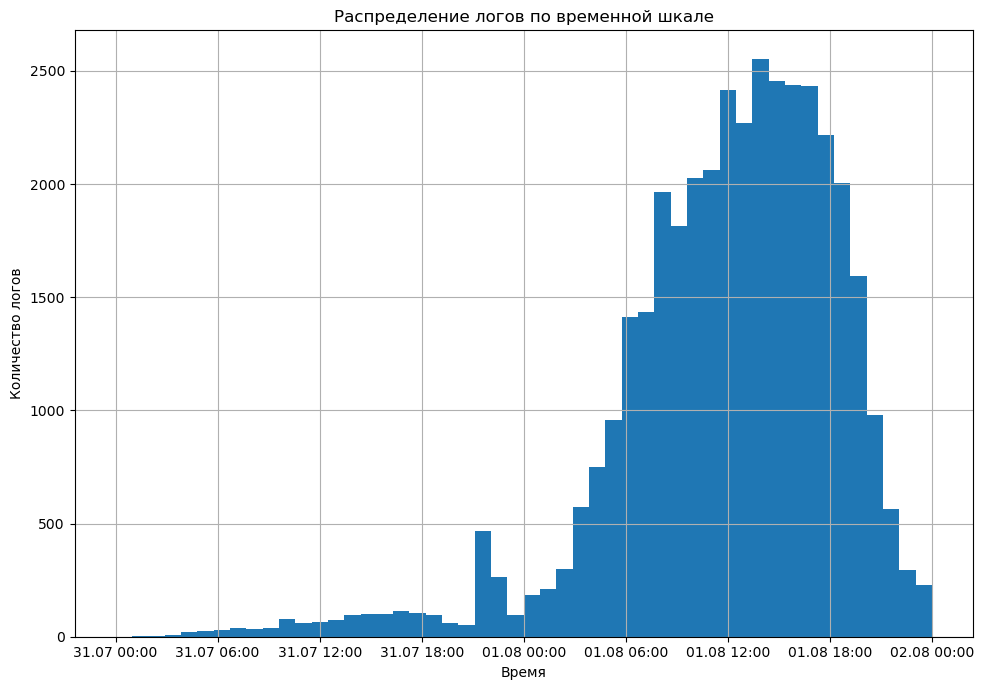

In [11]:
plt.figure(figsize=(10,7))
df['event_timestamp'].hist(bins=50, range=(pd.to_datetime('2019-07-31 00:00'), pd.to_datetime('2019-08-01 23:59')))

# Устанавливаем формат временных меток
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

plt.title('Распределение логов по временной шкале')
plt.ylabel('Количество логов')
plt.xlabel('Время')
plt.tight_layout()
plt.show()

- из более крупного приближения видно, что пользователи наиболее активно пользуются приложением в период с 12:00 до 18:00

**Посмотрим, как распределяется активность по времени в разрезе групп**

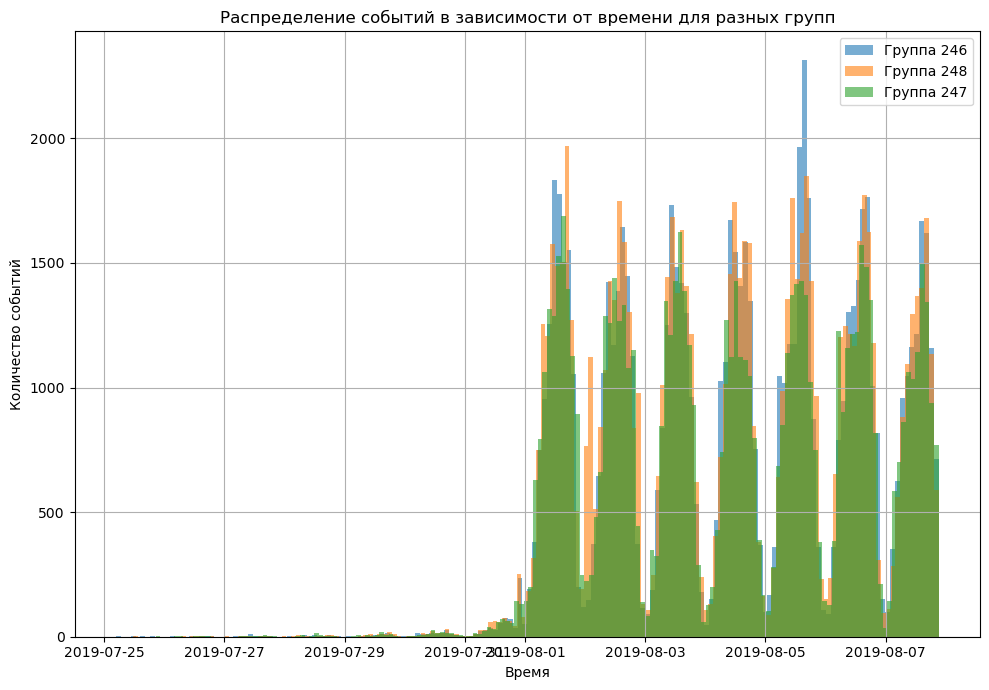

In [12]:
plt.figure(figsize=(10, 7))

# Группируем данные по exp_id и строим гистограмму для каждой группы
for group in df['exp_id'].unique():
    data = df[df['exp_id'] == group]['event_timestamp']
    data.hist(bins=168, alpha=0.6, label=f'Группа {group}')  # Устанавливаем прозрачность и метку

plt.title('Распределение событий в зависимости от времени для разных групп')
plt.xlabel('Время')
plt.ylabel('Количество событий')
plt.legend()
plt.tight_layout()
plt.show()

- на графике видно, что активность по группам распределена достаточно равномерно с небольшими отличиями в количестве, что отражает общее количество логов в каждой группе.


Для целей нашего анализа требуются максимально полные данные об активностях пользователей приложения. Судя по графикам, такие данные есть начиная с 01.08.2019 00:00, более ранние данные следует отбросить.

Таким образом, наш актуальный период данных с 25.07.2019 - 07.08.2019 сократится до **01.08.2019 - 07.08.2019**

- Посмотрим, какое количество записей мы потеряем? 


In [13]:
low_data = df.query('event_timestamp <= "2019-07-31 23:59"')
print('Следует удалить', len(low_data), 'записей, что составляет всего', round(len(low_data) / len(df) * 100, 2), '% от общего количества')

Следует удалить 2825 записей, что составляет всего 1.16 % от общего количества


**1,16% - допустимое количество удаляемых выбросов, так и поступим**

**Посмотрим также, сколько пользователей мы потеряем**

In [14]:
print('При удалении старых записей мы потеряем ',
low_data['device_id_hash'].nunique(),
' пользователей, что составляет ', round(low_data['device_id_hash'].nunique() / df['device_id_hash'].nunique(), 2),
' % от их общего числа.'
)

При удалении старых записей мы потеряем  1451  пользователей, что составляет  0.19  % от их общего числа.


In [15]:
df_filtered = df.query('event_timestamp > "2019-07-31 23:59"').reset_index(drop=True)
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240888 entries, 0 to 240887
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240888 non-null  object        
 1   device_id_hash   240888 non-null  int64         
 2   event_timestamp  240888 non-null  datetime64[ns]
 3   exp_id           240888 non-null  int64         
 4   event_date       240888 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.2+ MB
None


- посмотрим теперь на распределение активности по времени и группам

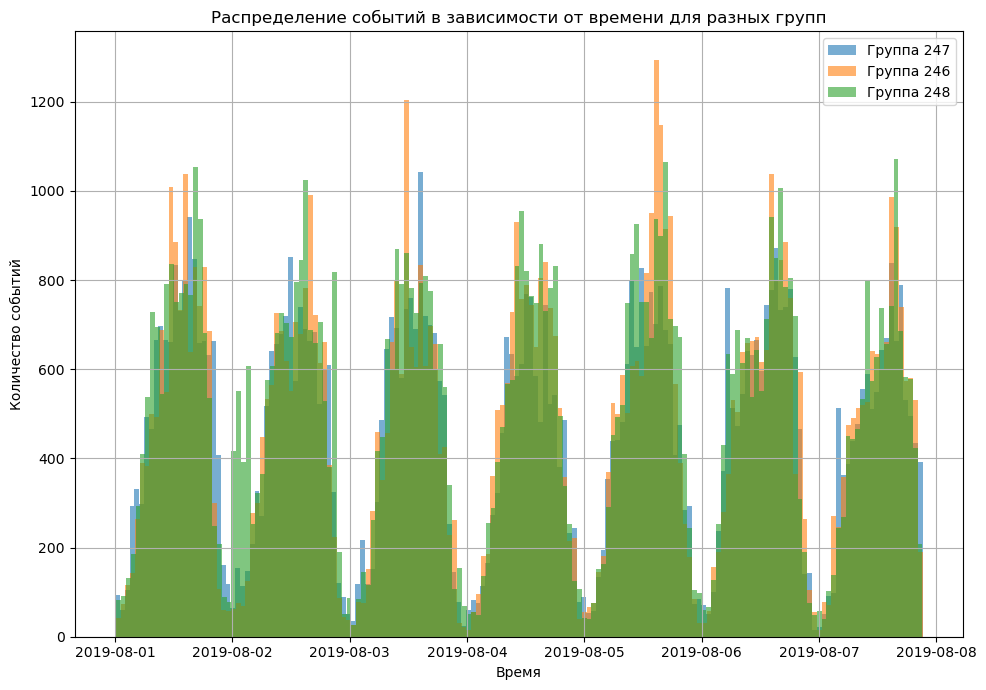

In [16]:
plt.figure(figsize=(10, 7))

# Группируем данные по exp_id и строим гистограмму для каждой группы
for group in df_filtered['exp_id'].unique():
    data = df_filtered[df_filtered['exp_id'] == group]['event_timestamp']
    data.hist(bins=168, alpha=0.6, label=f'Группа {group}')  # Устанавливаем прозрачность и метку

plt.title('Распределение событий в зависимости от времени для разных групп')
plt.xlabel('Время')
plt.ylabel('Количество событий')
plt.legend()
plt.tight_layout()
plt.show()

**Посмотрим, как распределяются уникальные пользователи по группам**

In [17]:
print(df_filtered.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


- пользователи поделены по группам примерно поровну, отлично

**Проверим, принадлежат ли уникальные пользователи каждый своей группе, или есть пользователи, которые попали более, чем в одну группу**
<a id="check1"></a>

In [18]:
print(df_filtered.groupby('device_id_hash')['exp_id'].nunique().sort_values(ascending=False))

device_id_hash
6888746892508752       1
6204944347213293942    1
6215559225876063378    1
6215162890135937308    1
6213626876710715478    1
                      ..
3171454373076660766    1
3170212200647575044    1
3167974726645136146    1
3167390091686880227    1
9222603179720523844    1
Name: exp_id, Length: 7534, dtype: int64


- получается, что с распределением по группам все в порядке - один пользователь = одна группа

# Итоги предварительной обрабоки данных

Нами были загружены логи событий приложения, исправлены названия колонок, данные о времени события приведены к нужному формату, удалены полные дубликаты (413 записей, стоит разобраться в причинах их появления), проверена коррекность распределения пользователей на группы, определены актуальные данные для анализа (начиная с 2019-08-01), более ранние неполные данные удалены 

## Изучим воронку событий

- посмотрим, сколько в логах событий каждого типа и сколько уникальных пользователей их совершало

In [19]:
# всего логов в базе
total_events = df_filtered.shape[0]

# посчитаем логи по каждому событию и % от общего количества
events = (df_filtered.groupby('event_name')
                 .agg({'exp_id':'count'})
                 .sort_values(by='exp_id', ascending=False)
                 .reset_index()
)
events.columns = ['event_name','events_count']
events['from_total'] = round(events['events_count'] / total_events * 100, 2)


display(events)

,event_name,events_count,from_total
0,MainScreenAppear,117329,48.71
1,OffersScreenAppear,46333,19.23
2,CartScreenAppear,42303,17.56
3,PaymentScreenSuccessful,33918,14.08
4,Tutorial,1005,0.42


- В офильтрованных нами данных есть логи 5 типов событий:
    - `MainScreenAppear` - это пользователь увидел главный экран приложения, другими словами, запустил его. **48.71%**  всех событий. По сути, это первый и обязательный пункт воронки. 
    - `OffersScreenAppear` - пользователь увидел экран с предложениями. **19,23%** событий. Без него не добавить товар в корзину.
    - `CartScreenAppear` - пользователь увидел корзину (не факт, что с размещенным им заказом. Можно корзину открыть и пустую - другой вопрос: зачем? Предположим, что этот пункт воронки говорит о предшествующем добавлении товара в корзину). Также следует отметить, что в корзину можно перейти сразу с главного экрана, минуя экран с предложениями. **17.56% событий**
    - `PaymentScreenSuccessful` - пользователь успешно оплатил заказ, **14,08% всех событий**. Этот пункт завершает нашу воронку
    - `Tutorial` - пользователь открыл экран с инструкциями по работе с приложением, **менее 0.5%** от всех событий. Данный пункт не является обязательным и может присутствовать в любом месте воронки.

- Сколько пользователей совершали каждое из этих событий?

In [20]:
events_users = (
    df_filtered.groupby('event_name')
    .agg({'device_id_hash': 'nunique'})
    .sort_values(by='device_id_hash', ascending=False)
    .reset_index()
)

events_users.columns = ['event_name', 'unique_users']
events_users['unique_users_change'] = events_users['unique_users'].pct_change() * 100

display(events_users)


,event_name,unique_users,unique_users_change
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,-38.091387
2,CartScreenAppear,3734,-18.702373
3,PaymentScreenSuccessful,3539,-5.222282
4,Tutorial,840,-76.264481


- Мы видим, как по мере прохождения воронки наши уникальные пользователи сокращают количество сеансов использования приложения: так после главного экрана на экран с предложениями переходит ***на 38% меньше пользователей***, что является весьма большим показателем для приложения для покупки продуктов. Возможно, у пользователей есть сложности с освоением работы с приложением и они просто не могут или не знают, как перейти на экран с предложениями. Либо переход осуществляется прямиком в корзину.

**Так или иначе - на этом шаге мы теряем наибольшее количество пользователей.**

В пользу этого предположения говорит крайне низкий % прохождения обучения работе с приложением - количество сеансов ***0.42%*** от общего числа событий в логе, как мы выяснили выше.

- После экрана с предложениями идет корзина, куда переходит ***на 18.70% меньше*** пользователей из предыдущего пункта. Как я уже заметил ранее, в корзину можно перейти и с главной страницы.
- Оплату успешно завершают ***всего на 5% меньшее*** количество пользователей от числа тех, кто добавил товар в корзину.

**Посмотрим, какое количество пользователей доходит от открытия приложения до оплаты:**

In [21]:
import plotly.express as px

data = df_filtered.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False).reset_index()

fig = px.funnel(data, x=data['device_id_hash'], y=data['event_name'])

# Обновление макета графика: убираем лейбл оси Y и добавляем заголовок
fig.update_layout(
    yaxis_title='',  # Убираем лейбл оси Y
    title='Воронка продаж: стадии воронки и количество уникальных пользователей на каждой',
    title_x=0.5,  # Центрируем заголовок
    title_xanchor='center'  # Указываем якорь для выравнивания заголовка
)


fig.show()

In [22]:
(print('Процент пользователей, которые доходят от открытия приложения до оплаты;',
round((events_users.loc[3, 'unique_users'] / events_users.loc[0, 'unique_users']) * 100, 2)
, '%')
)

Процент пользователей, которые доходят от открытия приложения до оплаты; 47.7 %


- менее 50%, есть куда расти. Например, расширить количество специальных предложений, персонифицировать их для пользователя на основе истории покупок и предпочений

**Стоит изучить, сколько проходит времени в среднем по пользователям каждой группы между первыми событиями MainScreenAppear и PaymentScreenSuccessful - от открытия приложения до покупки**

In [23]:
# Отфильтровать только нужные события
filtered_df = df_filtered[df_filtered['event_name'].isin(['MainScreenAppear', 'PaymentScreenSuccessful'])]

# Найти первое появление каждого события для каждого пользователя
first_events = filtered_df.groupby(['device_id_hash', 'event_name'])['event_timestamp'].min().unstack()

# Рассчитать время между событиями
first_events['time_difference'] = first_events['PaymentScreenSuccessful'] - first_events['MainScreenAppear']

# Преобразовать это обратно в формат DataFrame
first_events = first_events.reset_index()

# Мержим это обратно с оригинальным DataFrame
df_filtered = df_filtered.merge(first_events[['device_id_hash', 'time_difference']], on='device_id_hash', how='left')

# И выделяем в отдельный DataFrame с уникальными пользователями, временем до покупки и группой
df_filtered_time_to_purchase = df_filtered.groupby('device_id_hash').agg({'exp_id':'min', 'time_difference':'min'})

# Преобразовать timedelta в секунды
df_filtered_time_to_purchase['time_difference_sec'] = df_filtered_time_to_purchase['time_difference'].dt.total_seconds()

# Удалить строки с отрицательными значениями времени или NaN
df_filtered_time_to_purchase = df_filtered_time_to_purchase.dropna(subset=['time_difference_sec'])
first_events_clean = df_filtered_time_to_purchase[df_filtered_time_to_purchase['time_difference_sec'] > 0]

display(first_events_clean)

,exp_id,time_difference,time_difference_sec
device_id_hash,,,
6909561520679493,247,0 days 00:00:04,4.0
6922444491712477,246,0 days 00:00:07,7.0
7702139951469979,247,1 days 09:58:51,122331.0
9841258664663090,248,0 days 07:09:28,25768.0
18658818197810381,246,1 days 10:41:58,124918.0
...,...,...,...
9212420551954885212,248,0 days 00:03:09,189.0
9212961170535635779,246,4 days 10:45:37,384337.0
9214668690707156694,248,2 days 00:40:02,175202.0


- у нас есть данные времени между первым открытием приложения до первой покупки по всем уникальным пользоваелям.

**Посмотрим на график распределения**



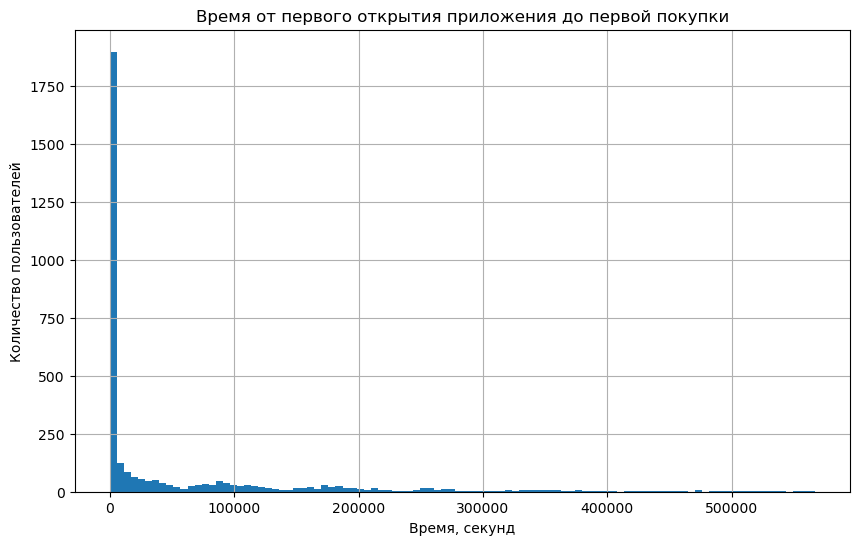

In [24]:
# общее распределение

plt.figure(figsize=(10,6))
first_events_clean['time_difference_sec'].hist(bins=100)
plt.xlabel('Время, секунд')
plt.ylabel('Количество пользователей')
plt.title('Время от первого открытия приложения до первой покупки')
plt.show()

- на графике видно, что большая часть пользователей совершает свою первую покупку практически сразу после открытия.
Более детально можно узнать из описательной статистики:

In [25]:
first_events_clean['time_difference_sec'].describe()

count      3268.000000
mean      53798.817013
std      101265.332728
min           1.000000
25%           9.000000
50%         396.000000
75%       67426.500000
max      566684.000000
Name: time_difference_sec, dtype: float64

**Медиана времени - 396 секунд**, или почти 7 минут. Интересно, какие значения будут у разных групп?

In [26]:
print('Статистика группы 246:\n')
first_events_clean.loc[first_events_clean['exp_id']==246]['time_difference_sec'].describe()


Статистика группы 246:



count      1100.000000
mean      54245.236364
std      102197.903640
min           1.000000
25%           9.000000
50%         409.000000
75%       71138.000000
max      527907.000000
Name: time_difference_sec, dtype: float64

In [27]:
print('Статистика группы 247:\n')
first_events_clean.loc[first_events_clean['exp_id']==247]['time_difference_sec'].describe()

Статистика группы 247:



count      1069.000000
mean      57449.418148
std      105815.831533
min           1.000000
25%           9.000000
50%         524.000000
75%       72709.000000
max      566684.000000
Name: time_difference_sec, dtype: float64

In [28]:
print('Статистика группы 248:\n')
first_events_clean.loc[first_events_clean['exp_id']==248]['time_difference_sec'].describe()

Статистика группы 248:



count      1099.000000
mean      49801.042766
std       95591.225207
min           1.000000
25%           9.500000
50%         297.000000
75%       54182.000000
max      559162.000000
Name: time_difference_sec, dtype: float64

**Вот, интересное наблюдение! Время, которое пользователи группы 248 затратили на покупку - наименьшее среди 3х групп:**
- 248 гр. = 297 секунд
- 247 гр. = 524 секунды
- 246 гр. = 409 секунд


Это может говорить нам о успешности нашего эксперимента со шрифтами, пользователи быстрее принимают решение о покупке.  

# Итоги исследования воронки событий:

Мы провели углубленную оценку данных о поведении пользователя на основе имеющихся данных логов и определили:
1. Типы событий и их количество
2. Самое раннее и позднее время события
3. Уникальных пользователей: 7551
4. Среднее количество событий на пользователя: 32.2756
5. Распределение логов и пользователей по группам теста
6. Статистику перехода по ступеням воронки: главных моментов 2
    - после главного экрана на экран с предложениями переходит на 38% меньше пользователей
    - крайне низкий % прохождения обучения работе с приложением - количество сеансов 0.42% от общего числа событий в логе.
7. Процент пользователей, которые доходят от открытия приложения до оплаты; 47.7 %. При этом на дороге от корзины до оплаты теряется лишь 5%

Также мы провели анализ данных времени, затрачиваемого пользователями разных групп на оплату (время с первого визита до первой оплаты) и обнаружили, что пользователи группы 248 (экспериментальной) показывают лучшие показатели.


## Изучим результаты эксперимента (тесты А/А/В)

**Выясним, как уникальные пользователи распределены по событиям и группам:**
- сначала вспомним, сколько уникальных пользователей в каждой группе 

In [29]:
print(df_filtered.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


- теперь посмотрим, как они распределены по событиям. *Другими словами, сколько пользоваелей хотя бы 1 раз открыли страницу*

In [30]:
users_events_groups = (
    df_filtered.groupby(['event_name', 'exp_id'])
                 .agg({'device_id_hash':'nunique'})
                 .reset_index()  
                 .pivot_table(index='event_name', columns='exp_id', values='device_id_hash')
                 
)
 
display(users_events_groups)

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


- Стоит обратить внимание на цифры MainScreenAppear по группам и их сравнение с числом пользователей, которое мы вывели ранее: выходит, что не все 100% пользователей увидели главный экран. Например, группа 246: пользователей 2484, а главный экран окрыли 2450, на 34 человека меньше. Как это возможно? 

Это возможно,, если человек открыл tutorial (попав при этом в наши логи, как уникальный пользователь), ничего там не понял и решил приложением не пользоваться. И таких пользователей у нас по группам получается столько:


In [31]:
unique_users_by_group = pd.DataFrame(df_filtered.groupby('exp_id')['device_id_hash'].nunique()).reset_index()
temp = users_events_groups.T.reset_index()

temp = temp.merge(unique_users_by_group, how='left', left_on='exp_id', right_on='exp_id')

gone_after_tutorial = pd.DataFrame()
gone_after_tutorial['group'] = temp['exp_id']
gone_after_tutorial['gone'] = temp['device_id_hash'] - temp['MainScreenAppear']

display(gone_after_tutorial)




,group,gone
0,246,34
1,247,37
2,248,44


- Посмотрим, как выглядит распределение по событиям и группам графически

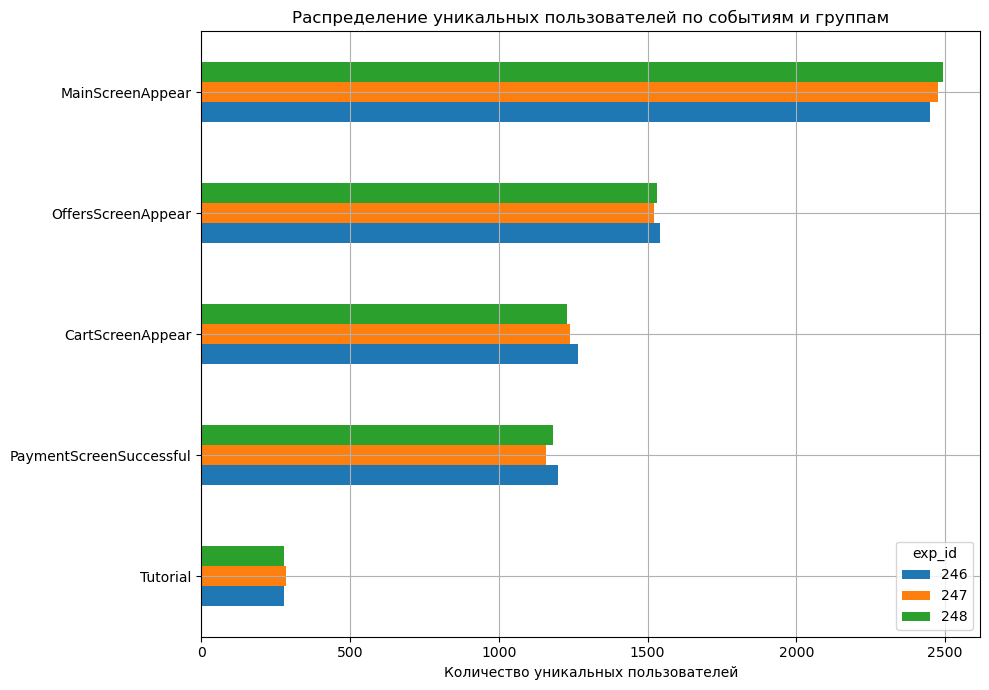

In [32]:
users_events_groups.sort_values(by=246).plot(kind='barh', figsize=(10, 7), grid = True)

plt.xlabel('Количество уникальных пользователей')
plt.ylabel('')
plt.title('Распределение уникальных пользователей по событиям и группам')
plt.tight_layout()
plt.show()

- из данных графика можно заключить, что, в целом, поведение пользователей во всех 3х группах похоже, больших "перекосов" нет. Выделить можно группу 246, пользователи из которой проходят воронку с большим количеством остающихся: в этой группе главный экран увидело наименьшее количество пользователей, а к выбору товара, добавлению в корзину и оплате перешло наибольшее

- касательно прохождения обучения (Tutorial) - количество уникальных пользователей во всех группах схожее и составляет ***всего 10%*** от количества пользователей, открывших приложение.

**Давайте узнаем, сколько раз в среднем пользователь из каждой группы видит страницу**

In [33]:

# Группировка с агрегацией и расчетом среднего значения через apply
avg_logs_per_user = (df.groupby(['event_name', 'exp_id'])
      .agg(unique_users=('device_id_hash', 'nunique'), 
           logs=('event_timestamp', 'count'),
           average_logs_per_user=('event_timestamp', lambda x: round(x.count() / df.loc[x.index, 'device_id_hash'].nunique(), 2)))
      .reset_index()
      .pivot_table(index='event_name', columns='exp_id', values=['unique_users', 'logs', 'average_logs_per_user'])
      .sort_values(by=('logs', 246), ascending=False)
      .reset_index())


display(avg_logs_per_user)

event_name average_logs_per_user                 logs  \
exp_id                                            246    247    248    246   
0              MainScreenAppear                 15.57  15.99  16.46  38249   
1            OffersScreenAppear                  9.65  10.03  10.77  14904   
2              CartScreenAppear                 11.65  10.12  12.37  14798   
3       PaymentScreenSuccessful                  9.91   8.65  10.27  11912   
4                      Tutorial                  1.14   1.21   1.26    318   

                     unique_users              
exp_id    247    248          246   247   248  
0       39677  41175         2456  2482  2501  
1       15341  16563         1545  1530  1538  
2       12548  15322         1270  1240  1239  
3       10039  12167         1202  1160  1185  
4         345    355          279   286   282

- по данной таблице видно, что 
    - во всех группах обучение открывают примерно 1 раз
    - пользователь группы 248 самый активный - среднее количество каждого события у этой группы наибольшее   
    - пользователь группы 247 отстает в среднем количестве открытия корзины и оплаты. Можно предположить, что результаты продаж в группе 247 тоже должны быть меньше

<a id='check2'></a>
## Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (А/А тест)

- Подготовим данные контрольный групп для теста и проведем z-тест пропорций на сравнение долей пользователей, совершивших покупку

In [34]:
display(df_filtered)

,event_name,device_id_hash,event_timestamp,exp_id,event_date,time_difference
0,MainScreenAppear,2413191300976302222,2019-07-31 23:59:59,247,2019-07-31,5 days 17:00:27
1,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,0 days 13:22:37
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,0 days 13:22:37
3,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,0 days 13:22:37
4,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,0 days 13:22:37
...,...,...,...,...,...,...
240883,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,0 days 02:05:23
240884,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,NaT
240885,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,0 days 00:00:18
240886,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,0 days 00:00:18


In [35]:
# считаем долю уникальных пользоваелей, совершивших покупку, от общего их числа в группе
purchased = (
    df_filtered.loc[df_filtered['event_name']=='PaymentScreenSuccessful']
    .groupby('exp_id').agg(
    purchased=('device_id_hash','nunique'))
    .reset_index()
)

total = (
    df_filtered
    .groupby('exp_id').agg(
    total=('device_id_hash','nunique'))
    .reset_index()
)

purchase_share = (
    purchased.merge(
    total,
    how='inner',
    left_on='exp_id',
    right_on='exp_id'
    )
)

purchase_share['share'] = round(purchase_share['purchased'] * 100 / purchase_share['total'], 2)

display(purchase_share)


,exp_id,purchased,total,share
0,246,1200,2484,48.31
1,247,1158,2513,46.08
2,248,1181,2537,46.55


- Проведем z-тест пропорций для групп 246/247, А/А тест. 

Нулевая гипотеза - пропорции равны, альтернативная гипотеза - пропорции отличаются.

Используем функцию proportions_ztest из библиотеки statsmodels, чтобы получить значение z-статистики и p-value.

Функция proportions_ztest принимает два аргумента:

**count**: количество успехов (в нашем случае, количество пользователей, совершивших "purchase") в каждой группе.

**nobs:** общее количество наблюдений (в нашем случае, общее количество пользователей) в каждой группе.

Полученное значение z-статистики и p-value покажет, есть ли статистически значимые различия между пропорциями двух групп. Если p-value меньше выбранного уровня значимости (например, 0.05), то нулевая гипотеза о равенстве пропорций отвергается.

In [36]:
count = purchase_share[purchase_share['exp_id'].isin([246, 247])]['purchased'].values
nobs = purchase_share[purchase_share['exp_id'].isin([246, 247])]['total'].values

# Проведение z-теста
z_stat, p_value = proportions_ztest(count, nobs)

print(f'z-statistic: {z_stat}, p-value: {p_value}')

z-statistic: 1.5779948491596598, p-value: 0.11456679313141847


**Итоговое заключение - тест показал нам `отсутствие статистически значимых различий` в пропорциях групп 246 и 247**

**Посчитаем число пользователей, совершивших самое популяное событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным с помощью z-test**

In [37]:
popular_events = (
    df_filtered.groupby(['event_name', 'exp_id'])['device_id_hash']
    .nunique()
    .reset_index()
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash')
    .reset_index()
    .sort_values(by=246, ascending=False)
    .reset_index(drop=True)
)

display(popular_events)


exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Самым популярным событием и по количеству уникальных пользователей и по количеству самого события является главный экран приложения - **MainScreenAppear**

Посчитаем долю пользователей, совершивших каждое из событий 


In [38]:
# сначала подсчитаем количество уникальных пользователей в каждой группе
users_by_group = df_filtered.groupby('exp_id')['device_id_hash'].nunique()

# теперь переберем в цикле все типы событий и посчитаем долю пользоваелей, их совершивших хотя бы раз 
rate_246 = []
rate_247 = []
rate_248 = []

for i, row in popular_events.iterrows():
    x = round(row[246] / users_by_group[246] * 100, 2)
    rate_246.append(x)
    x = round(row[247] / users_by_group[247] * 100, 2)
    rate_247.append(x)
    x = round(row[248] / users_by_group[248] * 100, 2)
    rate_248.append(x)


In [39]:
# добавим доли в общую таблицу
popular_events['rate_246'] = rate_246
popular_events['rate_247'] = rate_247
popular_events['rate_248'] = rate_248

display(popular_events)

exp_id,event_name,246,247,248,rate_246,rate_247,rate_248
0,MainScreenAppear,2450,2476,2493,98.63,98.53,98.27
1,OffersScreenAppear,1542,1520,1531,62.08,60.49,60.35
2,CartScreenAppear,1266,1238,1230,50.97,49.26,48.48
3,PaymentScreenSuccessful,1200,1158,1181,48.31,46.08,46.55
4,Tutorial,278,283,279,11.19,11.26,11.00


- также в таблицу добавим общее количество пользователей в каждой группе

In [40]:
popular_events['total_246'] = users_by_group[246]
popular_events['total_247'] = users_by_group[247]
popular_events['total_248'] = users_by_group[248]

display(popular_events)

exp_id,event_name,246,247,248,rate_246,rate_247,rate_248,total_246,total_247,total_248
0,MainScreenAppear,2450,2476,2493,98.63,98.53,98.27,2484,2513,2537
1,OffersScreenAppear,1542,1520,1531,62.08,60.49,60.35,2484,2513,2537
2,CartScreenAppear,1266,1238,1230,50.97,49.26,48.48,2484,2513,2537
3,PaymentScreenSuccessful,1200,1158,1181,48.31,46.08,46.55,2484,2513,2537
4,Tutorial,278,283,279,11.19,11.26,11.00,2484,2513,2537


**Напишем функцию для проверки z-тестом гипотезы о равенстве средних значений и передадим ей выборки доли пользователей по каждой группе и типу события.**  

Также надо учесть возможнось ошибки FWER при множественном проведении теста для одних данных. У нас 5 тестов (по числу типов событий), в которых мы используем данные пользователей из одной пары групп (246 и 247, например).

Следует провести коррекцию уровня значимости, используя Метод Бонферрони: если наш требуемый уровень значимости = 0.05, то при проведении 5 тестов его надо делать 0.05 / 5 =  **0.01**

In [41]:
def z_test(count, nobs, event):

    # Проведение z-теста
    z_stat, p_value = proportions_ztest(count, nobs)

    # Вывод результатов
    print(f'Результаты z-теста для события --  {event}')
    print(f'Z-статистика: {z_stat}')
    print(f'P-значение: {p_value}')

    # Интерпретация результатов
    alpha = 0.01 # с учетом поправки Метода Бонферрони 
    if p_value < alpha:
        print('Различие между долями статистически значимо.')
    else:
        print('Различие между долями статистически незначимо.')
    line()    

**Теперь для каждой пары групп (246 - 247, 246 - 248, 247 - 248) проведем тесты**

In [42]:
display(popular_events)

exp_id,event_name,246,247,248,rate_246,rate_247,rate_248,total_246,total_247,total_248
0,MainScreenAppear,2450,2476,2493,98.63,98.53,98.27,2484,2513,2537
1,OffersScreenAppear,1542,1520,1531,62.08,60.49,60.35,2484,2513,2537
2,CartScreenAppear,1266,1238,1230,50.97,49.26,48.48,2484,2513,2537
3,PaymentScreenSuccessful,1200,1158,1181,48.31,46.08,46.55,2484,2513,2537
4,Tutorial,278,283,279,11.19,11.26,11.00,2484,2513,2537


In [43]:
print('Тесты для групп 246 - 247\n')

for events in df_filtered['event_name'].unique():
    count = (popular_events[popular_events['event_name']==events][[246,247]].values.flatten()
    )
    total = (popular_events[popular_events['event_name']==events][['total_246','total_247']].values.flatten()
    )
    z_test(count, nobs, events)

Тесты для групп 246 - 247

Результаты z-теста для события --  MainScreenAppear
Z-статистика: 0.3093441851418436
P-значение: 0.7570597232046099
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  Tutorial
Z-статистика: -0.0781614596617372
P-значение: 0.9376996189257114
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  OffersScreenAppear
Z-статистика: 1.154987713610383
P-значение: 0.2480954578522181
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  CartScreenAppear
Z-статистика: 1.203368576486285
P-значение: 0.22883372237997213
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  PaymentScreenSuccessful


**Вердикт - между долями в группах 246 и 247 (контрольных) нет статистически значимых различий в разрезе каждого типа событий. Другими словами - поведение пользователей не отличаеся, значит А/А тест подтверждает правильность распределения пользователей по группам**

In [44]:
print('Тесты для групп 246 - 248\n')

for events in df_filtered['event_name'].unique():
    count = (popular_events[popular_events['event_name']==events][[246,248]].values.flatten()
    )
    total = (popular_events[popular_events['event_name']==events][['total_246','total_248']].values.flatten()
    )
    z_test(count, nobs, events)

Тесты для групп 246 - 248

Результаты z-теста для события --  MainScreenAppear
Z-статистика: -1.9584489179907973
P-значение: 0.050177359474672695
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  Tutorial
Z-статистика: 0.10035570401838094
P-значение: 0.920061935241805
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  OffersScreenAppear
Z-статистика: 0.838271269681762
P-значение: 0.4018783678293105
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  CartScreenAppear
Z-статистика: 1.4283986760811875
P-значение: 0.15317714002828972
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  PaymentScreenSuccessf

**Согласно результатам z-теста для групп 246 и 248, `нет оснований отвергнуть нулевую гипотезу о равенстве долей групп`** 

In [45]:
print('Тесты для групп 247 - 248\n')

for events in df_filtered['event_name'].unique():
    count = (popular_events[popular_events['event_name']==events][[247,248]].values.flatten()
    )
    total = (popular_events[popular_events['event_name']==events][['total_247','total_248']].values.flatten()
    )
    z_test(count, total, events)

Тесты для групп 247 - 248

Результаты z-теста для события --  MainScreenAppear
Z-статистика: 0.740980338642352
P-значение: 0.45870536166215137
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  Tutorial
Z-статистика: 0.2984969253006019
P-значение: 0.7653239224745011
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  OffersScreenAppear
Z-статистика: 0.1007086015299871
P-значение: 0.919781783059226
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  CartScreenAppear
Z-статистика: 0.5554019078073092
P-значение: 0.5786197879539782
Различие между долями статистически незначимо.
------------------------------------------------------------------
Результаты z-теста для события --  PaymentScreenSuccessful
Z

**Согласно результатам z-тестов по долям в группах 247 и 248, мы также можем заключить, что нулевую гипотезу о равенстве долей мы не можем отвергнуть**

# Итоги эксперимента

Мы провели исследования данных групп и тесты на сравнение долей. Результатом является следующие заключения:
1. Между группами 246 и 247 статистически значимых различий нет
2. Между группами 246 и 248  и 247 248 также нет статистически значимых различий   

# Финальные заключения и рекомендации

1. Следует обратить внимание на 2 этапа воронки:
- переход с главного экрана на экран предложений - мы теряем 38% пользователей на нем. Помогут дополнительные рассылки о спец. предложениях, персональные предложения на основе исории покупок и предпочтений.
- 5% пользователей после экрана формирования заказа (корзины) не переходят на страницу его оплаты. Следует
- обучение - всего 0.42% от логов, 1% пользователей после него перестали пользоваться приложением даже не начав. Стоит доработать этот блок.
- из общего количества пользователей всего 47.7% доходит до покупки, это большой потенциал для роста.
2. Тесты показали отсутствие влияние новых шрифтов на пользователей - нет смысла раскатывать их для всей аудитории.